# 📦 EfficientNetB0 Training for Waste Classification

Upgrade from MobileNetV2 to EfficientNetB0 for improved accuracy.

**Expected Improvements:**
- 92.8% → ~95-97% accuracy
- Better feature extraction
- Same inference speed for web app

## 1. Setup and Imports

In [11]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import yaml

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight

# Set project root
PROJECT_ROOT = Path(r"c:/Users/anike/Downloads/WasteSegregation")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("\n✅ Imports successful!")

Project Root: c:\Users\anike\Downloads\WasteSegregation
TensorFlow Version: 2.20.0
GPU Available: False

✅ Imports successful!


In [12]:
# Load configuration
config_path = PROJECT_ROOT / "config" / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Define paths
PROCESSED_DATA_PATH = PROJECT_ROOT / "datasets" / "processed"
MODELS_PATH = PROJECT_ROOT / "models" / "efficientnet"
MODELS_PATH.mkdir(parents=True, exist_ok=True)

# Also keep mobilenet path for easy replacement
MOBILENET_PATH = PROJECT_ROOT / "models" / "mobilenet"

# Classification configuration
DATASET_CONFIG = config['dataset']

# Image settings - EfficientNetB0 uses 224x224
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Smaller batch for better gradient updates
EPOCHS = 25  # More epochs with early stopping

# Class names
CLASS_NAMES = config['categories']['classification']
NUM_CLASSES = len(CLASS_NAMES)

print("📋 EfficientNetB0 Training Configuration:")
print("=" * 50)
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Max Epochs: {EPOCHS}")
print(f"   Classes: {CLASS_NAMES}")
print(f"   Number of Classes: {NUM_CLASSES}")

📋 EfficientNetB0 Training Configuration:
   Image Size: (224, 224)
   Batch Size: 16
   Max Epochs: 25
   Classes: ['recyclable', 'organic', 'e-waste', 'general']
   Number of Classes: 4


## 2. Verify Dataset

In [13]:
# Check dataset structure
print("📁 Dataset Structure:\n")

splits = ['train', 'val', 'test']
dataset_stats = {}

for split in splits:
    split_path = PROCESSED_DATA_PATH / split / "classification"
    print(f"📂 {split.upper()}:")
    
    if split_path.exists():
        split_stats = {}
        for category in CLASS_NAMES:
            cat_path = split_path / category
            if cat_path.exists():
                count = len(list(cat_path.glob("*.jpg")))
                split_stats[category] = count
                print(f"   {category}: {count} images")
        dataset_stats[split] = split_stats
    print()

📁 Dataset Structure:

📂 TRAIN:
   recyclable: 1868 images
   organic: 281 images
   e-waste: 281 images
   general: 355 images

📂 VAL:
   recyclable: 389 images
   organic: 60 images
   e-waste: 60 images
   general: 73 images

📂 TEST:
   recyclable: 392 images
   organic: 60 images
   e-waste: 60 images
   general: 73 images



## 3. Create Data Generators with Advanced Augmentation

In [14]:
# IMPORTANT: EfficientNet requires its own preprocessing function, NOT rescale=1./255
from tensorflow.keras.applications.efficientnet import preprocess_input

# Enhanced data augmentation for training
# NOTE: Do NOT use rescale with EfficientNet - use preprocessing_function instead
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet-specific preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/test - use same preprocessing function (no augmentation)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("📊 Creating data generators with EfficientNet preprocessing...\n")

# Training generator
train_generator = train_datagen.flow_from_directory(
    PROCESSED_DATA_PATH / "train" / "classification",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    PROCESSED_DATA_PATH / "val" / "classification",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

# Test generator
test_generator = val_datagen.flow_from_directory(
    PROCESSED_DATA_PATH / "test" / "classification",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

print(f"\n✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")
print(f"✅ Test samples: {test_generator.samples}")
print(f"\n⚠️ Using EfficientNet preprocessing (NOT rescale=1./255)")

📊 Creating data generators with EfficientNet preprocessing...

Found 2785 images belonging to 4 classes.
Found 582 images belonging to 4 classes.
Found 585 images belonging to 4 classes.

✅ Training samples: 2785
✅ Validation samples: 582
✅ Test samples: 585

⚠️ Using EfficientNet preprocessing (NOT rescale=1./255)


## 4. Compute Class Weights

In [15]:
# Compute class weights to handle imbalance
train_labels = train_generator.classes

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights_array))

print("⚖️ Class Weights (for balanced training):")
for idx, name in enumerate(CLASS_NAMES):
    print(f"   {name}: {class_weights[idx]:.4f}")

⚖️ Class Weights (for balanced training):
   recyclable: 0.3727
   organic: 2.4778
   e-waste: 2.4778
   general: 1.9613


## 5. Build EfficientNetB0 Model

In [16]:
def build_efficientnet_model(num_classes, input_shape=(224, 224, 3)):
    """
    Build EfficientNetB0 model with custom classification head.
    """
    # Load EfficientNetB0 with ImageNet weights (without top)
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Build custom head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Build model
model, base_model = build_efficientnet_model(NUM_CLASSES)

# Compile with label smoothing for better generalization
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()
print(f"\n📊 Total parameters: {model.count_params():,}")
print(f"📊 Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,679 (16.73 MB)

 Trainable params: 332,036 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)


📊 Total parameters: 4,384,679
📊 Trainable parameters: 332,036


## 6. Training Callbacks

In [17]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        str(MODELS_PATH / 'efficientnet_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured")

✅ Callbacks configured


## 7. Phase 1: Train Classification Head Only

In [18]:
print("🚀 Phase 1: Training classification head (frozen base)...")
print("=" * 60)

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n✅ Phase 1 complete!")
print(f"   Best validation accuracy: {max(history_phase1.history['val_accuracy']):.4f}")

🚀 Phase 1: Training classification head (frozen base)...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7120 - loss: 0.9789
Epoch 1: val_accuracy improved from None to 0.90206, saving model to c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\efficientnet_best.keras

Epoch 1: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\efficientnet_best.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.7530 - loss: 0.8255 - val_accuracy: 0.9021 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8426 - loss: 0.6149
Epoch 2: val_accuracy improved from 0.90206 to 0.91065, saving model to c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\efficientnet_best.keras

Epoch 2: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\efficientnet_best.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 68s 386ms/step - accuracy: 0.8452 - los

## 8. Phase 2: Fine-tune Top Layers

In [19]:
print("🔓 Unfreezing top layers for fine-tuning...")

# Unfreeze the top 30 layers of EfficientNet
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

trainable_count = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"📊 Trainable parameters after unfreezing: {trainable_count:,}")

🔓 Unfreezing top layers for fine-tuning...
📊 Trainable parameters after unfreezing: 1,828,196


In [20]:
print("🚀 Phase 2: Fine-tuning top layers...")
print("=" * 60)

# Update callbacks for phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        str(MODELS_PATH / 'efficientnet_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

print("\n✅ Phase 2 complete!")
print(f"   Best validation accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

🚀 Phase 2: Fine-tuning top layers...
Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8985 - loss: 0.4997
Epoch 1: val_accuracy improved from None to 0.94502, saving model to c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\efficientnet_best.keras

Epoch 1: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\efficientnet_best.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 98s 488ms/step - accuracy: 0.8966 - loss: 0.4939 - val_accuracy: 0.9450 - val_loss: 0.4914 - learning_rate: 1.0000e-04
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9043 - loss: 0.4663
Epoch 2: val_accuracy improved from 0.94502 to 0.94845, saving model to c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\efficientnet_best.keras

Epoch 2: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\efficientnet_best.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 84s 477ms/step - accuracy: 0.9056 - loss: 0.4765 - val_

## 9. Evaluate on Test Set

In [21]:
print("📊 Evaluating on test set...")
print("=" * 60)

# Load best model
best_model = keras.models.load_model(str(MODELS_PATH / 'efficientnet_best.keras'))

# Evaluate
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n🎯 Test Results:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

📊 Evaluating on test set...
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.9402 - loss: 0.4878

🎯 Test Results:
   Test Loss: 0.4878
   Test Accuracy: 0.9402 (94.02%)


37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step

📋 Classification Report:
              precision    recall  f1-score   support

  recyclable       0.98      0.93      0.95       392
     organic       1.00      1.00      1.00        60
     e-waste       1.00      1.00      1.00        60
     general       0.71      0.88      0.79        73

    accuracy                           0.94       585
   macro avg       0.92      0.95      0.93       585
weighted avg       0.95      0.94      0.94       585



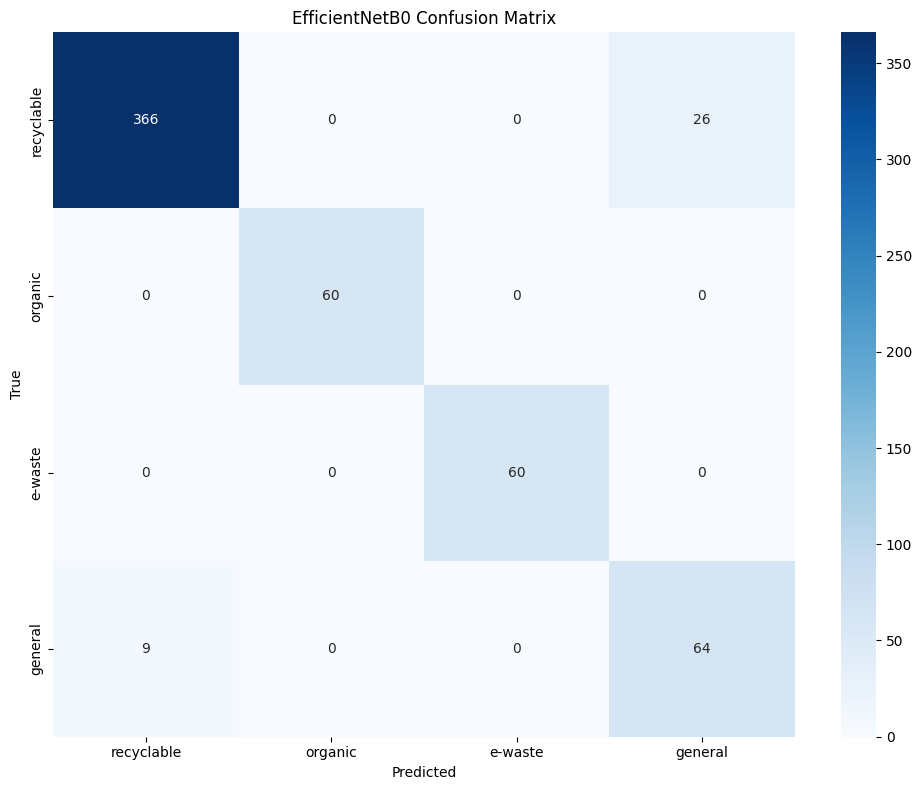

In [22]:
# Detailed classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print("\n📋 Classification Report:")
print("=" * 60)
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNetB0 Confusion Matrix')
plt.tight_layout()
plt.savefig(MODELS_PATH / 'confusion_matrix.png', dpi=150)
plt.show()

## 10. Plot Training History

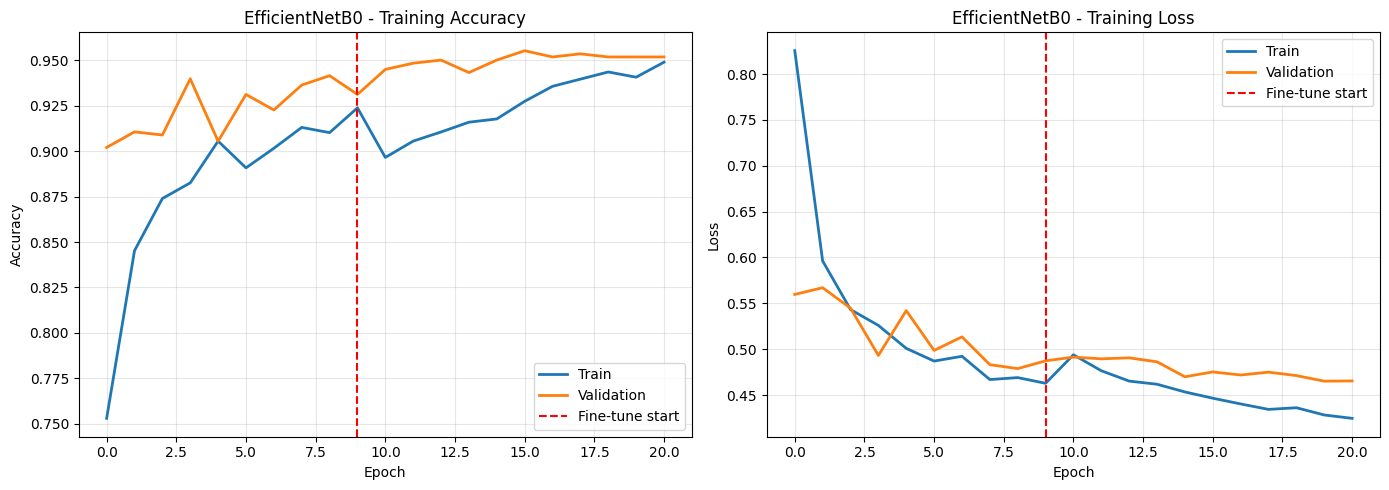

In [23]:
# Combine histories
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

full_history = combine_histories(history_phase1, history_phase2)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(full_history['accuracy'], label='Train', linewidth=2)
axes[0].plot(full_history['val_accuracy'], label='Validation', linewidth=2)
axes[0].axvline(x=len(history_phase1.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tune start')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('EfficientNetB0 - Training Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(full_history['loss'], label='Train', linewidth=2)
axes[1].plot(full_history['val_loss'], label='Validation', linewidth=2)
axes[1].axvline(x=len(history_phase1.history['loss'])-1, color='r', linestyle='--', label='Fine-tune start')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('EfficientNetB0 - Training Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_PATH / 'training_history.png', dpi=150)
plt.show()

## 11. Save Final Model & Integrate with Web App

In [ ]:
# Save final model to EfficientNet folder
final_model_path = MODELS_PATH / 'waste_classifier_efficientnet.keras'
best_model.save(str(final_model_path))
print(f"✅ Model saved to: {final_model_path}")

# Also save to MobileNet folder as the new classifier (for web app integration)
webapp_model_path = MOBILENET_PATH / 'waste_classifier_final.keras'

# Backup old model first
import shutil
old_model_path = MOBILENET_PATH / 'waste_classifier_final.keras'
if old_model_path.exists():
    backup_path = MOBILENET_PATH / 'waste_classifier_mobilenet_backup.keras'
    shutil.copy(old_model_path, backup_path)
    print(f"📦 Old MobileNet model backed up to: {backup_path}")

# Copy new model to replace the old one
shutil.copy(final_model_path, webapp_model_path)
print(f"✅ EfficientNet model deployed to: {webapp_model_path}")

# Update app.py to use EfficientNet preprocessing
app_py_path = PROJECT_ROOT / "app.py"
app_content = app_py_path.read_text(encoding='utf-8')
app_content = app_content.replace("USE_EFFICIENTNET = False", "USE_EFFICIENTNET = True")
app_py_path.write_text(app_content, encoding='utf-8')
print(f"✅ Updated app.py to use EfficientNet preprocessing")

print("\n🚀 Web app will now use EfficientNetB0 automatically!")

✅ Model saved to: c:\Users\anike\Downloads\WasteSegregation\models\efficientnet\waste_classifier_efficientnet.keras
📦 Old MobileNet model backed up to: c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\waste_classifier_mobilenet_backup.keras
✅ EfficientNet model deployed to: c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\waste_classifier_final.keras


UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 1315: character maps to <undefined>

## 12. Test Integration

In [ ]:
# Test that the model loads correctly (same as web app)
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

print("🧪 Testing web app integration...")
print("=" * 60)

# Load model the same way app.py does
test_load = keras.models.load_model(str(webapp_model_path))
print("✅ Model loads successfully!")

# Test with a sample image
from PIL import Image

# Get a test image
test_images_dir = PROCESSED_DATA_PATH / "test" / "classification"
sample_class = CLASS_NAMES[0]  # recyclable
sample_images = list((test_images_dir / sample_class).glob("*.jpg"))

if sample_images:
    sample_path = sample_images[0]
    img = Image.open(sample_path).resize((224, 224))
    img_array = np.array(img, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    
    # IMPORTANT: Use EfficientNet preprocessing (NOT divide by 255)
    img_array = efficientnet_preprocess(img_array)
    
    # Predict
    prediction = test_load.predict(img_array, verbose=0)
    predicted_class = CLASS_NAMES[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    print(f"\n📷 Test Image: {sample_path.name}")
    print(f"   True Class: {sample_class}")
    print(f"   Predicted: {predicted_class}")
    print(f"   Confidence: {confidence:.2%}")
    print(f"\n   All probabilities:")
    for i, name in enumerate(CLASS_NAMES):
        print(f"   - {name}: {prediction[0][i]:.2%}")

## 13. Summary

In [ ]:
print("\n" + "=" * 60)
print("📊 EFFICIENTNETB0 TRAINING SUMMARY")
print("=" * 60)
print(f"\n🎯 Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\n📁 Model saved to:")
print(f"   - {MODELS_PATH / 'waste_classifier_efficientnet.keras'}")
print(f"   - {MOBILENET_PATH / 'waste_classifier_final.keras'} (web app)")
print(f"\n✅ Integration complete! Restart Flask app to use the new model.")
print("\n" + "=" * 60)